In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

conn = sqlite3.connect(r"../../diplom.db")
cur = conn.cursor()

In [2]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from VZGLYAD;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

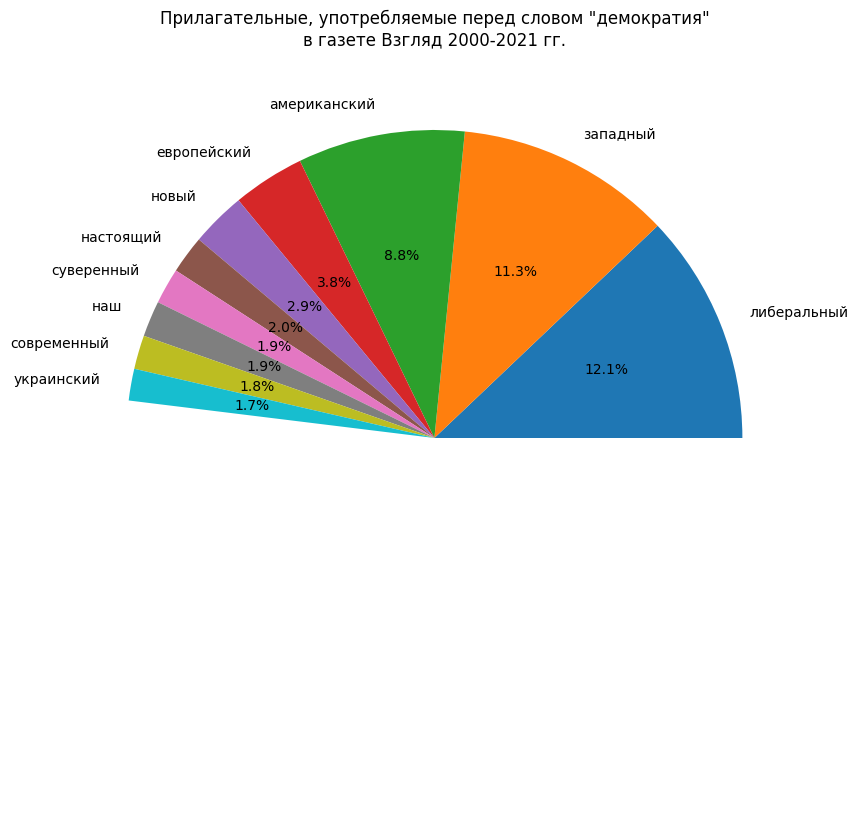

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
rus = adj[["Слово", "Процент"]].head(10)
rus.loc[10, "Слово"] = "Ост."
rus.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(rus["Процент"], labels=rus["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nв газете Взгляд 2000-2021 гг.')
fig.savefig("vzglyad_adj_ru.png")

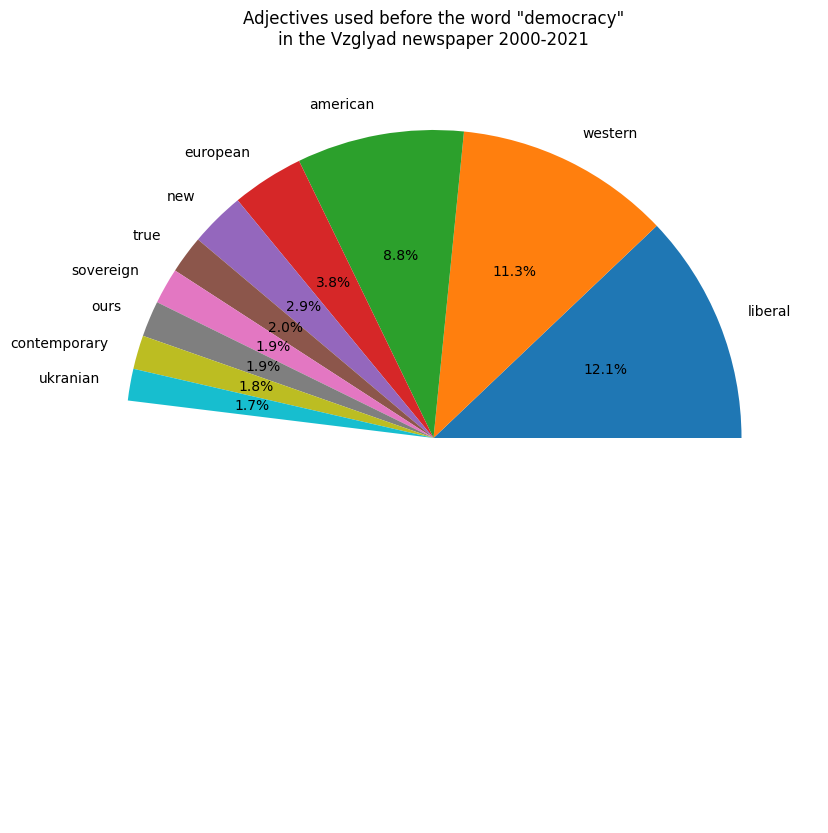

In [4]:
eng = rus.copy()
eng['Word'] = ['liberal', 'western', 'american', 'european', 'new', 'true', 'sovereign', 'ours', 'contemporary', 'ukranian', 'rest']
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
wedge, text, procent = ax.pie(rus["Процент"], labels=eng["Word"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Adjectives used before the word "democracy"\nin the Vzglyad newspaper 2000-2021')
fig.savefig("vzglyad_adj_en.png")

In [8]:
%%time
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from VZGLYAD""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5)
model.save("vzglyad.model")
model.wv.save("vzglyad.wordvectors")
model.wv.most_similar('демократия')

CPU times: total: 17min 15s
Wall time: 8min 43s


[('демократический', 0.705778181552887),
 ('либерализм', 0.6594206094741821),
 ('диктатура', 0.6432538032531738),
 ('светоч', 0.5974670648574829),
 ('тоталитаризм', 0.5753818154335022),
 ('социализм', 0.5693466067314148),
 ('демократичный', 0.5667052865028381),
 ('свобода', 0.5615435242652893),
 ('политкорректность', 0.5565980672836304),
 ('капитализм', 0.555891215801239)]

In [19]:
cur.close()
conn.close()